In [38]:
# Importing libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn import preprocessing

# Ignoring warnings for library versions in the output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading data from sqllite file
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')

In [4]:
# Listing tables
df_tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)
df_tables

,name
0,spatial_ref_sys
1,spatialite_history
2,sqlite_sequence
3,geometry_columns
4,spatial_ref_sys_aux
5,views_geometry_columns
6,virts_geometry_columns
7,geometry_columns_statistics
8,views_geometry_columns_statistics
9,virts_geometry_columns_statistics


In [18]:
# Fires is the main table holding the wildfire details
df_fire = pd.read_sql("select * from {}".format('Fires'), conn)
df_fire.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [11]:
# Display the shape of the dataset
df_fire.shape

(1880465, 39)

In [7]:
# Columns in the Fires table
df_fire.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [12]:
# Identifying null values for each column
df_fire.isnull().sum(axis=0)

OBJECTID                            0
FOD_ID                              0
FPA_ID                              0
SOURCE_SYSTEM_TYPE                  0
SOURCE_SYSTEM                       0
NWCG_REPORTING_AGENCY               0
NWCG_REPORTING_UNIT_ID              0
NWCG_REPORTING_UNIT_NAME            0
SOURCE_REPORTING_UNIT               0
SOURCE_REPORTING_UNIT_NAME          0
LOCAL_FIRE_REPORT_ID          1459286
LOCAL_INCIDENT_ID              820821
FIRE_CODE                     1555636
FIRE_NAME                      957189
ICS_209_INCIDENT_NUMBER       1854748
ICS_209_NAME                  1854748
MTBS_ID                       1869462
MTBS_FIRE_NAME                1869462
COMPLEX_NAME                  1875282
FIRE_YEAR                           0
DISCOVERY_DATE                      0
DISCOVERY_DOY                       0
DISCOVERY_TIME                 882638
STAT_CAUSE_CODE                     0
STAT_CAUSE_DESCR                    0
CONT_DATE                      891531
CONT_DOY    

In [19]:
# Ignoring the columns with null values and picking only one column for similar information. 
# Such as STAT_CAUSE_CODE and STAT_CAUSE_DESCR provides similar information therefore selected only STAT_CAUSE_DESCR
features = ['FIRE_YEAR','STAT_CAUSE_DESCR','LATITUDE','LONGITUDE','STATE','DISCOVERY_DATE','FIRE_SIZE']
df_fire_subset = df_fire[features]
df_fire_subset.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,0.25
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,0.10
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,0.10


In [20]:
# DISCOVERY_DATE is in Julian format. Converting to Gregorian format
df_fire_subset['DISCOVERY_DT'] = pd.to_datetime(df_fire_subset['DISCOVERY_DATE'] - pd.Timestamp(0).to_julian_date(), unit='D')
df_fire_subset.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DISCOVERY_DT
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2005-02-02
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,2004-05-12
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,2004-05-31
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,2004-06-28
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,2004-06-28


In [23]:
# Extracting month and day from DISCOVERY_DT for further analysis
df_fire_subset['DISCOVERY_MONTH'] = pd.DatetimeIndex(df_fire_subset['DISCOVERY_DT']).month
df_fire_subset['DISCOVERY_DAY'] = df_fire_subset['DISCOVERY_DT'].dt.day_name()
df_fire_subset.head()

,FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE,DISCOVERY_DT,DISCOVERY_MONTH,DISCOVERY_DAY
0,2005,Miscellaneous,40.036944,-121.005833,CA,2453403.5,0.10,2005-02-02,2,Wednesday
1,2004,Lightning,38.933056,-120.404444,CA,2453137.5,0.25,2004-05-12,5,Wednesday
2,2004,Debris Burning,38.984167,-120.735556,CA,2453156.5,0.10,2004-05-31,5,Monday
3,2004,Lightning,38.559167,-119.913333,CA,2453184.5,0.10,2004-06-28,6,Monday
4,2004,Lightning,38.559167,-119.933056,CA,2453184.5,0.10,2004-06-28,6,Monday


In [24]:
# Keeping a copy of the dataset for later use
df_copy = df_fire_subset.copy()

### Data Exploration

Analyzing cause of fire

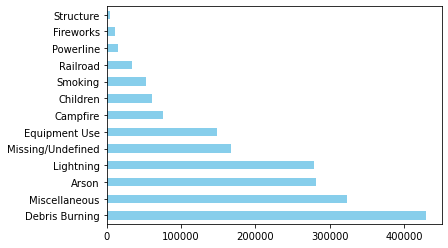

In [32]:
df_fire_subset['STAT_CAUSE_DESCR'].value_counts().plot(kind='barh',color='skyblue')
plt.show()

Exploring which days of week were fires more discovered

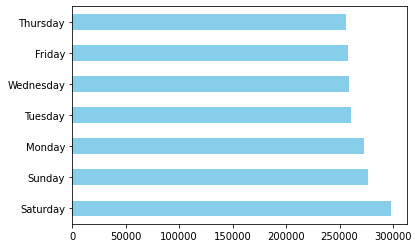

In [33]:
df_fire_subset['DISCOVERY_DAY'].value_counts().plot(kind='barh',color='skyblue')
plt.show()

Checking which states have more fire. Only top 10 states are identified

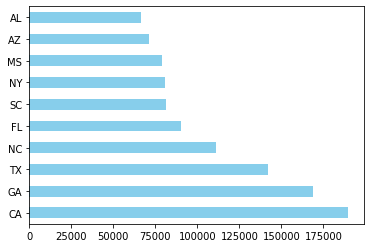

In [34]:
df_fire_subset['STATE'].value_counts().head(n=10).plot(kind='barh',color='skyblue')
plt.show()

California and Texas are in top 3 and can be correlated to the fact that they are dry state

#### Plotting correlartion matrix to better understand the relationship

Identify non-numeric attributes in the dataset

In [36]:
df_fire_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 10 columns):
 #   Column            Dtype         
---  ------            -----         
 0   FIRE_YEAR         int64         
 1   STAT_CAUSE_DESCR  object        
 2   LATITUDE          float64       
 3   LONGITUDE         float64       
 4   STATE             object        
 5   DISCOVERY_DATE    float64       
 6   FIRE_SIZE         float64       
 7   DISCOVERY_DT      datetime64[ns]
 8   DISCOVERY_MONTH   int64         
 9   DISCOVERY_DAY     object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(3)
memory usage: 143.5+ MB


In [37]:
# STAT_CAUSE_DESCR, STATE, and DISCOVERY_DAY needs to be converted to categorical attributes
encoder = preprocessing.LabelEncoder()
df_fire_subset['STAT_CAUSE_DESCR'] = encoder.fit_transform(df_fire_subset['STAT_CAUSE_DESCR'])
df_fire_subset['STATE'] = encoder.fit_transform(df_fire_subset['STATE'])
df_fire_subset['DISCOVERY_DAY'] = encoder.fit_transform(df_fire_subset['DISCOVERY_DAY'])
print(df_fire_subset.head())

   FIRE_YEAR  STAT_CAUSE_DESCR   LATITUDE   LONGITUDE  STATE  DISCOVERY_DATE  \
0       2005                 7  40.036944 -121.005833      4       2453403.5   
1       2004                 6  38.933056 -120.404444      4       2453137.5   
2       2004                 3  38.984167 -120.735556      4       2453156.5   
3       2004                 6  38.559167 -119.913333      4       2453184.5   
4       2004                 6  38.559167 -119.933056      4       2453184.5   

   FIRE_SIZE DISCOVERY_DT  DISCOVERY_MONTH  DISCOVERY_DAY  
0       0.10   2005-02-02                2              6  
1       0.25   2004-05-12                5              6  
2       0.10   2004-05-31                5              1  
3       0.10   2004-06-28                6              1  
4       0.10   2004-06-28                6              1  


<AxesSubplot:>

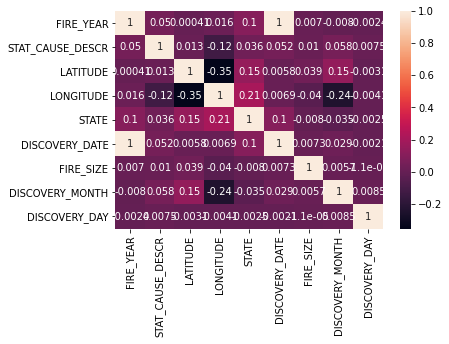

In [39]:
# Generating correlation matrix
df_corr = df_fire_subset.corr()

# Generating heatmap based on the correlation matrix
sns.heatmap(df_corr,annot=True)

From the plot, some strong correlation can be seen between month and latitude, assuming could be related to weather and season. Though no strong correlation is seen between longitude and month. The class variable "STAT_CAUSE_DESCRIPTION" does not show any particularly strong correlation with any other data feature, perhaps a weak correlation with MONTH, YEAR and DISCOVERY_DATE.